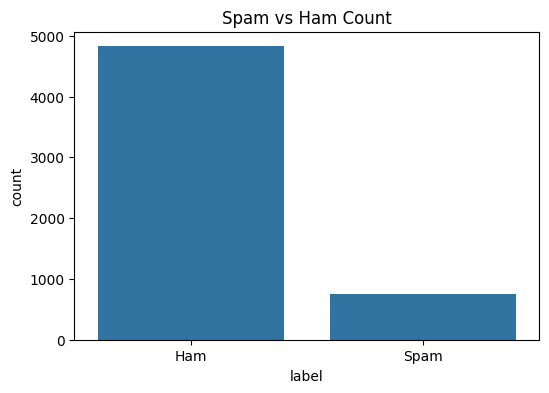

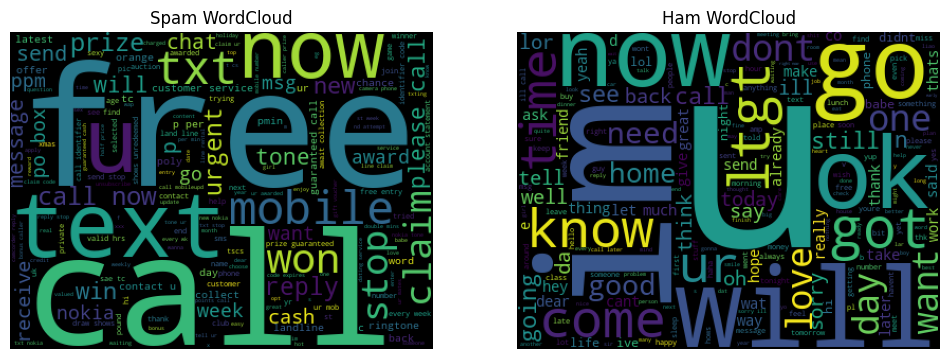

Best Naive Bayes Parameters: {'nb__alpha': 0.1}
Best SVM Parameters: {'svm__C': 10}
Best Random Forest Parameters: {'rf__max_depth': None, 'rf__n_estimators': 200}

 Accuracy: 0.9766816143497757

 Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99       965
           1       1.00      0.83      0.91       150

    accuracy                           0.98      1115
   macro avg       0.99      0.91      0.95      1115
weighted avg       0.98      0.98      0.98      1115



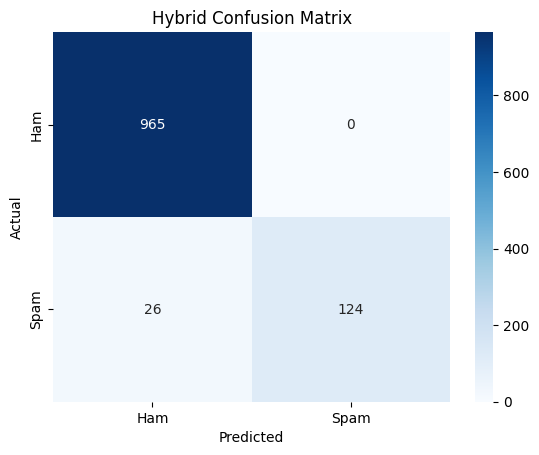

['models/tfidf_vectorizer.pkl']

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
import re
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
import joblib

df = pd.read_csv('data.csv')[['v1', 'v2']]
df.columns = ['label', 'message']
df.dropna(inplace=True)
df['label'] = df['label'].map({'spam': 1, 'ham': 0})

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)  
    text = text.translate(str.maketrans('', '', string.punctuation))  
    text = text.strip()  
    return text

df['cleaned'] = df['message'].apply(clean_text)


plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df)
plt.title("Spam vs Ham Count")
plt.xticks([0, 1], ['Ham', 'Spam'])
plt.show()

from wordcloud import WordCloud

spam_words = ' '.join(list(df[df['label'] == 1]['cleaned']))
ham_words = ' '.join(list(df[df['label'] == 0]['cleaned']))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(WordCloud(width=400, height=300).generate(spam_words))
plt.axis('off')
plt.title('Spam WordCloud')

plt.subplot(1, 2, 2)
plt.imshow(WordCloud(width=400, height=300).generate(ham_words))
plt.axis('off')
plt.title('Ham WordCloud')
plt.show()

vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))
X = vectorizer.fit_transform(df['cleaned'])
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', ngram_range=(1, 2))),
    ('nb', MultinomialNB())
])
nb_params = {'nb__alpha': [0.1, 0.5, 1.0]}
nb_grid = GridSearchCV(nb_pipeline, nb_params, cv=5, scoring='accuracy')
nb_grid.fit(df['cleaned'], y)
print("Best Naive Bayes Parameters:", nb_grid.best_params_)

svm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', ngram_range=(1, 2))),
    ('svm', LinearSVC(max_iter=10000))
])
svm_params = {'svm__C': [0.1, 1, 10]}
svm_grid = GridSearchCV(svm_pipeline, svm_params, cv=5, scoring='accuracy')
svm_grid.fit(df['cleaned'], y)
print("Best SVM Parameters:", svm_grid.best_params_)

rf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', ngram_range=(1, 2))),
    ('rf', RandomForestClassifier())
])
rf_params = {'rf__n_estimators': [50, 100, 200], 'rf__max_depth': [10, 20, None]}
rf_grid = GridSearchCV(rf_pipeline, rf_params, cv=5, scoring='accuracy')
rf_grid.fit(df['cleaned'], y)
print("Best Random Forest Parameters:", rf_grid.best_params_)


nb_model = nb_grid.best_estimator_.named_steps['nb']
svm_model = svm_grid.best_estimator_.named_steps['svm']
rf_model = rf_grid.best_estimator_.named_steps['rf']

hybrid = VotingClassifier(estimators=[
    ('nb', nb_model),
    ('svm', svm_model),
    ('rf', rf_model)
], voting='hard')

hybrid.fit(X_train, y_train)
y_pred = hybrid.predict(X_test)

print("\n Accuracy:", accuracy_score(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title("Hybrid Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

joblib.dump(hybrid, 'models/hybrid_model.pkl')
joblib.dump(vectorizer, 'models/tfidf_vectorizer.pkl')

In [1]:
import joblib

model = joblib.load('models/hybrid_model.pkl')

vectorizer = joblib.load('models/tfidf_vectorizer.pkl')
text = ["Congratulations! You've won a free iPhone!"]
text_2=["Hello i want to talk to you about the project"]
text_vec = vectorizer.transform(text)
text_vec_2 = vectorizer.transform(text_2)
prediction = model.predict(text_vec)
prediction_2 = model.predict(text_vec_2)

print("Spam " if prediction[0] == 1 else "Ham ")
print("Spam " if prediction_2[0] == 1 else "Ham ")

Spam 
Ham 


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, Conv1D, GlobalMaxPooling1D
import numpy as np 

df = pd.read_csv("data.csv", usecols=[0, 1], names=["v1", "v2"], skiprows=1)


le = LabelEncoder()
df['label'] = le.fit_transform(df['v1']) 


tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(df['v2'])
sequences = tokenizer.texts_to_sequences(df['v2'])


maxlen = max([len(x) for x in sequences]) 

padded = pad_sequences(sequences, padding='post', maxlen=maxlen) 
X_train, X_test, y_train, y_test = train_test_split(
    padded, df['label'], test_size=0.2, random_state=42)
neg, pos = np.bincount(df['label'])
total = neg + pos
class_weight = {0: (1 / neg) * (total / 2.0), 1: (1 / pos) * (total / 2.0)}
vocab_size = len(tokenizer.word_index) + 1
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=maxlen),
    Conv1D(128, 5, activation='relu'), 
    GlobalMaxPooling1D(), 
    Dense(64, activation='relu'),
    Dropout(0.5), 
    Dense(32, activation='relu'),
    Dropout(0.5), 
    Dense(1, activation='sigmoid')  
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), batch_size=64, class_weight=class_weight)

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

def predict_message(msg):
    seq = tokenizer.texts_to_sequences([msg])
    pad = pad_sequences(seq, maxlen=maxlen, padding='post')
    pred = model.predict(pad)
    return "Spam" if pred[0][0] > 0.5 else "Ham"

print(predict_message("Congratulations! You've won a free ticket!"))
print(predict_message("Hey, can we meet tomorrow?"))